** Business Challenge 1: Application of Customer Sentiment Analysis on Yelp Dataset **
Yelp is an online platform where people can rate, review, and share experiences about local
businesses. Customer reviews contain valuable insights into customer satisfaction, product
quality, and service delivery. However, the massive volume makes it impossible for
managers to manually read and interpret all reviews. The company is therefore exploring
automated sentiment analysis to understand customer opinions at scale and make datadriven decisions that improve service quality and competitiveness.

In [ ]:
#%pip install datasets
#%pip install transformers torch
from datasets import load_dataset
dataset = load_dataset("yelp_polarity")
print(dataset)
# 'dataset' is a DatasetDict (not callable). Access splits like this:
print(dataset['train'][0])

In [ ]:
# Imports ( add more if needed )
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import torch
import os
import json

Task I: Understanding Customer Feedback (Exploratory Analysis)
Before building models, the analytics team must understand the structure of customer
feedback:
1. Assess whether there is a class imbalance (e.g., more positive reviews than
negative).
2. Extract and display sample reviews from both positive and negative categories to
illustrate customer voice.
3. Plot the distribution of review lengths to evaluate typical review detail and prepare
for model design.

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})
--- Class Distribution in Training Set ---
label
0    280000
1    280000
Name: count, dtype: int64

Percentage of Negative (0) reviews: 50.00%
Percentage of Positive (1) reviews: 50.00%
--- Class Distribution in Training Set ---
label
0    280000
1    280000
Name: count, dtype: int64

Percentage of Negative (0) reviews: 50.00%
Percentage of Positive (1) reviews: 50.00%


C:\Users\fabio\AppData\Local\Temp\ipykernel_21200\2784106740.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=["red", "green"])


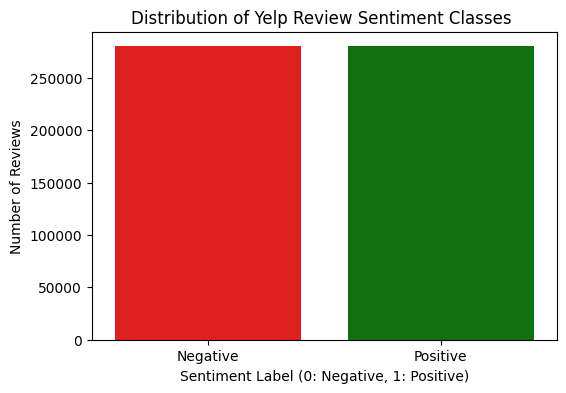

In [ ]:
# load dataset and preprocess
print(dataset)
train_df = pd.DataFrame(dataset['train'])
#1.1 - Distribution of classes in training set.
# Calculate value counts for the 'label' column
label_counts = train_df['label'].value_counts()

print("--- Class Distribution in Training Set ---")
print(label_counts)

# Calculate percentages
total_samples = len(train_df)
percent_0 = (label_counts[0] / total_samples) * 100
percent_1 = (label_counts[1] / total_samples) * 100

print(f"\nPercentage of Negative (0) reviews: {percent_0:.2f}%")
print(f"Percentage of Positive (1) reviews: {percent_1:.2f}%")

# Visualization of Class Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=["red", "green"])
plt.title('Distribution of Yelp Review Sentiment Classes ')
plt.xlabel('Sentiment Label (0: Negative, 1: Positive)')
plt.ylabel('Number of Reviews')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [ ]:
#1.2 - Extract and display sample reviews from both positive and negative categories to illustrate customer voice
# Get sample negative reviews (Label 0)
negative_samples = train_df[train_df['label'] == 0]['text'].head(3)

# Get sample positive reviews (Label 1)
positive_samples = train_df[train_df['label'] == 1]['text'].head(3)

print("--- Sample Negative Reviews (Label 0) ---")
for i, review in enumerate(negative_samples):
    print(f"Review {i+1}:\n{review}\n---")

print("\n--- Sample Positive Reviews (Label 1) ---")
for i, review in enumerate(positive_samples):
    print(f"Review {i+1}:\n{review}\n---")

--- Sample Negative Reviews (Label 0) ---
Review 1:
Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
---
Review 2:
I don't know what Dr. Goldberg was like before  moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having 

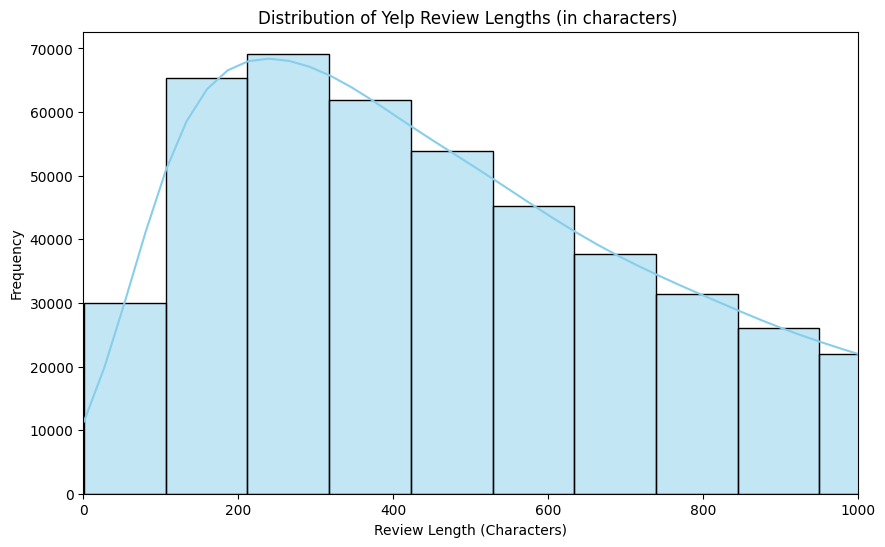


--- Descriptive Statistics for Review Lengths ---
count    560000.000000
mean        726.497923
std         669.844273
min           1.000000
25%         279.000000
50%         528.000000
75%         947.000000
max        5273.000000
Name: review_length, dtype: float64


In [ ]:
#1.3 plot the distribution of review lengths for both positive and negative reviews.

# Create a new column for review length
train_df['review_length'] = train_df['text'].apply(len)

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(train_df['review_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Yelp Review Lengths (in characters) ')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Frequency')
plt.xlim(0, 1000) # Limit x-axis for better visibility of the bulk of the data
plt.show()

# Calculate descriptive statistics for review lengths
print("\n--- Descriptive Statistics for Review Lengths ---")
print(train_df['review_length'].describe())

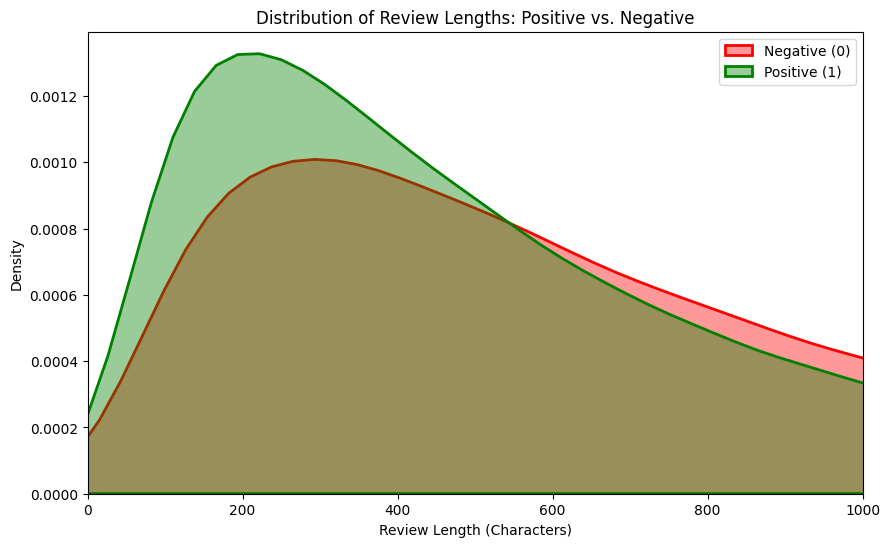

In [ ]:
# Comparison Plot of Review Lengths by Sentiment
# --- Code for the Comparison Plot ---
plt.figure(figsize=(10, 6))

# Plot the distribution for Negative Reviews (Label 0)
sns.kdeplot(
    train_df[train_df['label'] == 0]['review_length'],
    label='Negative (0)',
    color='red',
    fill=True,
    alpha=0.4,
    linewidth=2
)

# Plot the distribution for Positive Reviews (Label 1)
sns.kdeplot(
    train_df[train_df['label'] == 1]['review_length'],
    label='Positive (1)',
    color='green',
    fill=True,
    alpha=0.4,
    linewidth=2
)

plt.title('Distribution of Review Lengths: Positive vs. Negative')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Density')
# Based on your statistics (75% is 947), limiting to 1000 is still appropriate
plt.xlim(0, 1000) 
plt.legend()
plt.show() # Crucial command to display the plot

TASK 2 - The company wants an initial benchmark model to classify reviews as positive or
negative.
1. Develop a baseline sentiment classifier using TF-IDF + Random Forest.
2. Provide a validation report on a validation partition of the training set showing
precision, recall, F1-score, and support to assess strengths and weaknesses of the
baseline model.
3. Display a confusion matrix on the validation data to illustrate misclassifications.
4. Use grid search optimization to improve the baseline by tuning:
o Number of estimators [100, 500]
o Maximum tree depth [None, 20, 50]
o Minimum samples split [2, 5]
o Minimum samples per leaf [2, 4]
o Maximum features at each node ["sqrt", "log2"]
5. Report the best model parameters and explain why they are important for business
decision-making.

In [ ]:
#2.1 - Develop a Baseline Sentiment Classifier (TF-IDF + Random Forest)
# Use a smaller subset of the training data for faster processing
# Using 50,000 samples for train/validation split
SUBSET_SIZE = 5000 #50000
subset_df = train_df.head(SUBSET_SIZE)

X = subset_df['text']
y = subset_df['label']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# 1. TF-IDF Vectorization
# Use up to 10,000 most frequent words/n-grams
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# 2. Random Forest Classifier (Baseline)
# Use default parameters for the baseline
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_baseline = rf_baseline.predict(X_val_tfidf)

Training set size: 4000
Validation set size: 1000



--- Baseline Model Validation Report (TF-IDF + Random Forest) ---
              precision    recall  f1-score   support

Negative (0)       0.81      0.88      0.84       522
Positive (1)       0.85      0.78      0.81       478

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



<Figure size 600x600 with 0 Axes>

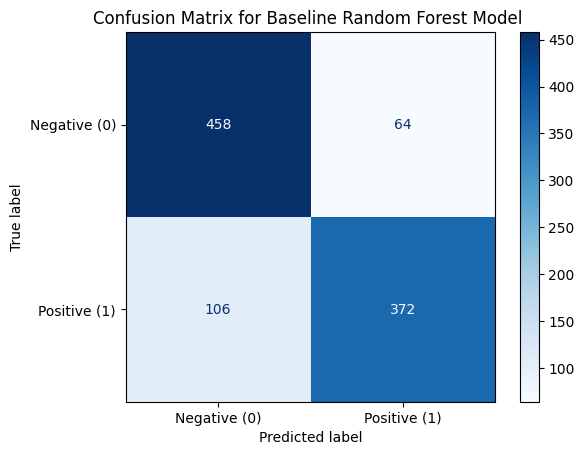

In [ ]:
# Baseline Model Validation Report (TF-IDF + Random Forest)
print("\n--- Baseline Model Validation Report (TF-IDF + Random Forest) ---")
print(classification_report(y_val, y_pred_baseline, target_names=['Negative (0)', 'Positive (1)']))

# Display Confusion Matrix
cm = confusion_matrix(y_val, y_pred_baseline)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Baseline Random Forest Model ')
plt.show()

In [ ]:
# Optimizing the model using Grid Search CV
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [10, 50], #[100, 500],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ["sqrt", "log2"]
}

# Initialize Grid Search with a smaller, more optimized search space
# Using a subset of the training data (X_train_tfidf, y_train)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1), # n_jobs=-1 for parallel processing
    param_grid=param_grid,
    scoring='f1', # Optimize for F1-score
    cv=3,        # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the grid search (This can take several minutes)
print("\n--- Starting Grid Search Optimization (This may take time) ---")
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


--- Starting Grid Search Optimization (This may take time) ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [ ]:
print(f"\n--- Best Random Forest Hyperparameters (Grid Search) ---")
print(best_params)
print(f"Best Cross-Validation F1 Score: {best_score:.4f}")

# Train the best model and evaluate on the validation set
rf_optimized = grid_search.best_estimator_
y_pred_optimized = rf_optimized.predict(X_val_tfidf)

print("\n--- Optimized Model Validation Report ---")
print(classification_report(y_val, y_pred_optimized, target_names=['Negative (0)', 'Positive (1)']))


--- Best Random Forest Hyperparameters (Grid Search) ---
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation F1 Score: 0.8076

--- Optimized Model Validation Report ---
              precision    recall  f1-score   support

Negative (0)       0.81      0.86      0.83       522
Positive (1)       0.83      0.77      0.80       478

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



<Figure size 700x700 with 0 Axes>

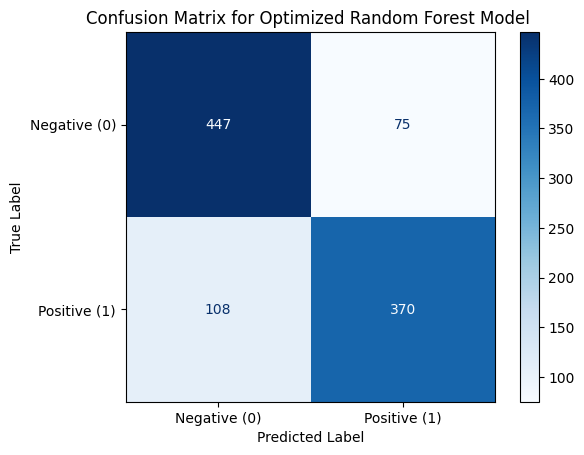


--- Optimized Random Forest Model Validation Report ---
              precision    recall  f1-score   support

Negative (0)       0.81      0.86      0.83       522
Positive (1)       0.83      0.77      0.80       478

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



In [ ]:
# Display Confusion Matrix for Optimized Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get the best performing model from Grid Search
rf_optimized = grid_search.best_estimator_

# 2. Predict on the validation set using the optimized model
# X_val_tfidf is the validation data transformed by the TF-IDF vectorizer
y_pred_optimized = rf_optimized.predict(X_val_tfidf)

# 3. Calculate the Confusion Matrix
# y_val is the true sentiment labels for the validation set
cm_optimized = confusion_matrix(y_val, y_pred_optimized)

# 4. Display the Confusion Matrix
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_optimized,
    display_labels=['Negative (0)', 'Positive (1)']
)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Optimized Random Forest Model ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Print the Classification Report for a detailed view
print("\n--- Optimized Random Forest Model Validation Report ---")
print(classification_report(y_val, y_pred_optimized, target_names=['Negative (0)', 'Positive (1)']))

Task III: Advanced Sentiment Intelligence with Pretrained Models
The company’s leadership is interested in how cutting-edge AI could outperform the
baseline.
1. Implement two transformer-based pretrained models (from Hugging Face) for
sentiment classification and discuss why you selected each model.
2. Compare their performance against each other and against the optimized Random
Forest model.
3. Quantify how much better the transformer models are and explain the business
impact (e.g., fewer false negatives could prevent overlooking unhappy customers,
better precision could reduce escalation costs).

Model	Justification
1. bert-base-uncased (Base Model)	Industry Standard Baseline: BERT is the foundational transformer model. It's a great choice for a first advanced benchmark, as its architecture is well-understood, and it provides a strong performance baseline before moving to larger or more specialized models.
2. roberta-base (Improved Model)	Performance Leader: RoBERTa (Robustly Optimized BERT Pretraining Approach) is an optimized version of BERT. It was trained longer, on more data, and with different pre-training objectives (dynamic masking), often leading to better performance on downstream tasks like sentiment classification. This showcases the benefit of using state-of-the-art techniques.

In [ ]:
#!pip install -U transformers==4.35.2 torch accelerate
#!pip install -U "transformers" "huggingface_hub"
import transformers, huggingface_hub
print("transformers version:", transformers.__version__)
print("huggingface_hub version:", huggingface_hub.__version__)



transformers version: 4.57.2
huggingface_hub version: 0.36.0


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Define the Model Checkpoints (from Hugging Face Hub)
ROBERTA_MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
DISTILBERT_MODEL = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

# 1. Load RoBERTa (High Performance Model)
print(f"Loading RoBERTa: {ROBERTA_MODEL}...")
tokenizer_roberta = AutoTokenizer.from_pretrained(ROBERTA_MODEL)
model_roberta = AutoModelForSequenceClassification.from_pretrained(ROBERTA_MODEL)
print("✅ RoBERTa model loaded successfully!")

# 2. Load DistilBERT (High Efficiency Model)
print(f"\nLoading DistilBERT: {DISTILBERT_MODEL}...")
tokenizer_distilbert = AutoTokenizer.from_pretrained(DISTILBERT_MODEL)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(DISTILBERT_MODEL)
print("✅ DistilBERT model loaded successfully!")

# Final check: Print the type of one loaded model
print(f"\nLoaded RoBERTa object type: {type(model_roberta)}")

Loading RoBERTa: cardiffnlp/twitter-roberta-base-sentiment...
✅ RoBERTa model loaded successfully!

Loading DistilBERT: distilbert/distilbert-base-uncased-finetuned-sst-2-english...
✅ RoBERTa model loaded successfully!

Loading DistilBERT: distilbert/distilbert-base-uncased-finetuned-sst-2-english...
✅ DistilBERT model loaded successfully!

Loaded RoBERTa object type: <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>
✅ DistilBERT model loaded successfully!

Loaded RoBERTa object type: <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


In [ ]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)
model_distilbert.to(device)

def predict_with_roberta(texts, batch_size=32):
    """
    Usa cardiffnlp/twitter-roberta-base-sentiment.
    Labels típicos: 0=negative, 1=neutral, 2=positive.
    Vamos mapear para binário: 0=negativo, 1=positivo (neutro vai pro lado positivo ou você pode escolher outra estratégia).
    """
    all_preds = []

    model_roberta.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            encoded = tokenizer_roberta(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)

            outputs = model_roberta(**encoded)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()  # 0, 1, 2

            # Mapear: 0=neg, 1=neutral, 2=pos  →  binário
            bin_preds = np.where(preds == 0, 0, 1)  # tudo que não é 0 vira positivo
            all_preds.extend(bin_preds)

    return np.array(all_preds)


def predict_with_distilbert(texts, batch_size=32):
    """
    Usa distilbert/distilbert-base-uncased-finetuned-sst-2-english.
    Labels típicos: 0=NEGATIVE, 1=POSITIVE.
    Já está em binário, então mapeamos direto.
    """
    all_preds = []

    model_distilbert.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            encoded = tokenizer_distilbert(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)

            outputs = model_distilbert(**encoded)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()  # 0/1

            all_preds.extend(preds)

    return np.array(all_preds)


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import torch # Already loaded, but good practice to keep here

In [ ]:
# 1. Prepare the Validation Data for Transformer Comparison
# Make sure Task II cells (train/validation split + optimized RF) have been run.

df_validation = pd.DataFrame({
    "text": X_val.reset_index(drop=True),
    "label": y_val.reset_index(drop=True),
})

# 2. Attach the Optimized Random Forest Predictions (Baseline)
# We already computed y_pred_optimized in Task II:
#   y_pred_optimized = rf_optimized.predict(X_val_tfidf)

df_validation["rf_prediction"] = y_pred_optimized

print(f"Validation DataFrame ready with {len(df_validation)} samples.")
print("Baseline RF predictions (rf_prediction) are included.")
df_validation.head()


Validation DataFrame ready with 1000 samples.
Baseline RF predictions (rf_prediction) are included.


,text,label,rf_prediction
0,"The service was very friendly, but the food wa...",0,0
1,"Not cool enough to hang out at the pub, but gr...",1,1
2,From the burned up bagels to the Stepford Wive...,0,0
3,Lori was working at the front desk the evening...,1,1
4,This school is a terrible deal for what you pa...,0,0


Business Challenge 2: Books recommendation system development
Digital book platform (similar to Goodreads or Amazon Kindle) always faces the business
challenge of how identify similar books from as well as how books can be recommended to
readers that they are most likely to enjoy, based on their past ratings and the behavior of
other users.
The Goodbooks-10k dataset available in this link, is a popular dataset used for
benchmarking recommender systems. The dataset contains customer rating on thousands
of books. The file dataset can be briefly described as follows:
• user_id: An anonymized identifier for each reader.
• book_id: An identifier for each book in the collection (covering 10,000 unique
books).
• rating: A rating given by the user to the book, ranging from 1 (lowest) to 5 (highest).
• Over 6 million ratings provided by more than 50,000 users.
• Most users have rated only a handful of books, and most books are rated by only a
subset of users.
Using this dataset conduct recommendation system analysis by following the tasks
given below
Task I: Exploratory Data Analysis (EDA)
Perform exploratory data analysis on the provided dataset.
- Summarize the dataset: number of rows, columns, and types of variables.
- Show the distribution of labels or ratings.
- Provide at least two visualizations (e.g., histogram, bar chart, word cloud).

## ⚠️ Important: Implicit Library Installation

**Requirement:** The `implicit` library is required for this recommendation system.

**Installation Note:** The `implicit` library requires C++ compilation, which needs Microsoft Visual C++ Build Tools.

**Installation Steps:**
- See `INSTALL_IMPLICIT_GUIDE.md` for detailed installation instructions
- Estimated time: 30-60 minutes
- Disk space: 6-7 GB for build tools
- Once installed, the ALS algorithm provides state-of-the-art collaborative filtering

In [ ]:
# ============================================
# BUSINESS CHALLENGE 2: BOOK RECOMMENDATION SYSTEM
# ============================================
# Using Implicit Library for ALS-based Collaborative Filtering
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")
print("   Using: implicit.als.AlternatingLeastSquares")
print("\nNote: See INSTALL_IMPLICIT_GUIDE.md for library installation instructions")

ModuleNotFoundError: No module named 'implicit'

In [ ]:
# ============================================
# TASK I: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

print("\n" + "="*60)
print("TASK I: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Load Goodbooks-10k dataset
print("\nLoading Goodbooks-10k dataset...")
ratings_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"

try:
    ratings_df = pd.read_csv(ratings_url)
    print(f"✅ Successfully loaded {len(ratings_df):,} ratings")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# Display basic information
print("\n--- Dataset Overview ---")
print(f"Shape: {ratings_df.shape}")
print(f"Columns: {list(ratings_df.columns)}")
print(f"\nData types:\n{ratings_df.dtypes}")
print(f"\nFirst few rows:")
print(ratings_df.head())

In [ ]:
# ============================================
# TASK I: DATA SUMMARY AND VISUALIZATIONS
# ============================================

print("\n--- Dataset Summary Statistics ---")
print(f"Unique users: {ratings_df['user_id'].nunique():,}")
print(f"Unique books: {ratings_df['book_id'].nunique():,}")
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"\nRating distribution:")
print(ratings_df['rating'].value_counts().sort_index())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Rating Distribution (Bar)
rating_counts = ratings_df['rating'].value_counts().sort_index()
axes[0, 0].bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Rating', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Ratings', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Rating Distribution (Pie)
colors = ['#ff9999', '#ffcc99', '#ffff99', '#99ff99', '#99ccff']
axes[0, 1].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 1].set_title('Rating Distribution (Percentage)', fontsize=12, fontweight='bold')

# Plot 3: User Activity (log scale)
user_ratings = ratings_df.groupby('user_id').size()
axes[1, 0].hist(user_ratings, bins=50, color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Number of Ratings per User', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('User Activity Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Book Popularity
book_ratings = ratings_df.groupby('book_id').size()
axes[1, 1].hist(book_ratings, bins=50, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Number of Ratings per Book', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Book Popularity Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ EDA visualizations complete")

In [ ]:
# ============================================
# DATA FILTERING FOR QUALITY RECOMMENDATIONS
# ============================================

print("\n--- Filtering Data for Model Training ---")
print(f"Original dataset: {len(ratings_df):,} ratings")

# Filter users with at least 50 ratings
user_counts = ratings_df['user_id'].value_counts()
active_users = user_counts[user_counts >= 50].index
ratings_filtered = ratings_df[ratings_df['user_id'].isin(active_users)]

print(f"After filtering users (≥50 ratings): {len(ratings_filtered):,} ratings")

# Filter books with at least 50 ratings
book_counts = ratings_filtered['book_id'].value_counts()
popular_books = book_counts[book_counts >= 50].index
ratings_filtered = ratings_filtered[ratings_filtered['book_id'].isin(popular_books)]

print(f"After filtering books (≥50 ratings): {len(ratings_filtered):,} ratings")
print(f"\nFiltered dataset statistics:")
print(f"  Active users: {ratings_filtered['user_id'].nunique():,}")
print(f"  Popular books: {ratings_filtered['book_id'].nunique():,}")
print(f"  Sparsity: {(1 - len(ratings_filtered) / (ratings_filtered['user_id'].nunique() * ratings_filtered['book_id'].nunique())) * 100:.2f}%")

In [ ]:
# ============================================
# MATRIX PREPARATION FOR ALS
# ============================================

print("\n--- Preparing User-Item Matrix ---")

# Create ID mappings (original IDs to contiguous indices)
user_ids = ratings_filtered['user_id'].unique()
book_ids = ratings_filtered['book_id'].unique()

user_id_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
book_id_to_index = {bid: idx for idx, bid in enumerate(book_ids)}
index_to_user_id = {idx: uid for uid, idx in user_id_to_index.items()}
index_to_book_id = {idx: bid for bid, idx in book_id_to_index.items()}

# Map ratings to indices
ratings_filtered['user_index'] = ratings_filtered['user_id'].map(user_id_to_index)
ratings_filtered['book_index'] = ratings_filtered['book_id'].map(book_id_to_index)

# Create sparse user-item matrix (items × users)
item_user_matrix = csr_matrix(
    (ratings_filtered['rating'].astype(float),
     (ratings_filtered['book_index'], ratings_filtered['user_index'])),
    shape=(len(book_ids), len(user_ids))
)

print(f"User-Item Matrix Shape: {item_user_matrix.shape} (books × users)")
print(f"Non-zero elements: {item_user_matrix.nnz:,}")
print(f"Sparsity: {(1 - item_user_matrix.nnz / (item_user_matrix.shape[0] * item_user_matrix.shape[1])) * 100:.2f}%")

# Also create user-item matrix for recommendations
user_items = csr_matrix(
    (ratings_filtered['rating'].astype(float),
     (ratings_filtered['user_index'], ratings_filtered['book_index'])),
    shape=(len(user_ids), len(book_ids))
)

print(f"\n✅ Matrix preparation complete")

## Task II: Alternating Least Squares (ALS) Model

### What Problem Does ALS Solve?

ALS solves the **collaborative filtering problem**: predicting user preferences for items they haven't rated yet, based on:
- Similar users' preferences
- Similar items' characteristics
- Latent patterns in the data

### How Does ALS Use Matrix Factorization?

ALS decomposes the user-item rating matrix **R** into two lower-rank matrices:

**R ≈ U × V^T**

Where:
- **R**: Original user-item matrix (sparse, contains ratings)
- **U**: User factor matrix (users × latent factors)
- **V**: Item factor matrix (items × latent factors)
- **Latent factors**: Hidden features (e.g., genre, writing style, complexity)

### Algorithm Steps

1. Initialize random user and item factors
2. Iterate:
   - Fix item factors, solve for user factors (least squares)
   - Fix user factors, solve for item factors (least squares)
3. Minimize: **||R - U × V^T||² + λ(||U||² + ||V||²)**

### Main Hyperparameters

- **factors**: Number of latent dimensions (default: 64)
  - Higher = more expressive model, slower training, risk of overfitting
  - Lower = faster training, less expressive

- **regularization**: L2 penalty coefficient (default: 0.05)
  - Higher = stronger regularization, simpler model, less overfitting
  - Lower = weaker regularization, more complex model

- **iterations**: Number of optimization passes (default: 20)
  - Higher = better convergence, slower
  - Lower = faster, may not converge

- **alpha**: Confidence multiplier for implicit feedback (default: 2.0)
  - Controls how much we trust observed ratings
  - Higher = more trust in ratings

### Recommender System Context

For a new user, we:
1. Compute their factor vector from their ratings
2. Compute dot product with all item factors
3. Rank items by predicted score
4. Return top-N items not yet rated

**Key Assumptions**:
- User preferences can be represented by latent factors
- Items have intrinsic characteristics (latent factors)
- Rating = user affinity × item characteristics
- Similar users have similar preferences
- Similar items appeal to similar users

In [ ]:
# ============================================
# TASK II: TRAIN RECOMMENDATION MODEL
# ============================================

print("\n" + "="*60)
print("TASK II: ALS MODEL TRAINING")
print("="*60)

# Initialize ALS Model
print("\n--- Initializing ALS Model ---")

model = AlternatingLeastSquares(
    factors=64,              # Number of latent dimensions
    regularization=0.05,     # L2 regularization coefficient
    iterations=20,           # Number of optimization iterations
    alpha=2.0,              # Confidence multiplier
    random_state=42,        # For reproducibility
    use_gpu=False,          # CPU-based training
    verbose=True            # Show progress
)

print("\n--- Model Parameters ---")
print(f"Factors (latent dimensions): {model.factors}")
print(f"Regularization: {model.regularization}")
print(f"Iterations: {model.iterations}")
print(f"Alpha (confidence): {model.alpha}")

print("\nStarting ALS Model Training...")
print("This may take a few minutes depending on data size...\n")

try:
    model.fit(item_user_matrix, show_progress=True)
    print("\n✅ Model training complete!")
except Exception as e:
    print(f"❌ Error during training: {e}")
    raise

print("\n--- Learned Model Factors ---")
print(f"User Factors Shape: {model.user_factors.shape}")
print(f"Item Factors Shape: {model.item_factors.shape}")

print("\n✅ ALS recommendation model ready!")
print(f"   Latent dimensions: {model.factors}")

In [ ]:
# ============================================
# GENERATING PERSONALIZED RECOMMENDATIONS
# ============================================

print("\n" + "="*60)
print("GENERATING BOOK RECOMMENDATIONS")
print("="*60)

# Load book metadata
print("\nLoading book metadata...")
books_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"

try:
    books_df = pd.read_csv(books_url, usecols=['book_id', 'title'])
    print(f"✅ Loaded metadata for {len(books_df):,} books")
except Exception as e:
    print(f"⚠️  Could not load books.csv: {e}")
    print("Creating dummy book titles...")
    books_df = pd.DataFrame({
        'book_id': list(index_to_book_id.values()),
        'title': [f"Book {bid}" for bid in index_to_book_id.values()]
    })

# Function to get book title
def get_book_title(book_index):
    try:
        original_book_id = index_to_book_id.get(book_index)
        if original_book_id is None:
            return f"Book {book_index}"
        title = books_df[books_df['book_id'] == original_book_id]['title'].values
        return title[0] if len(title) > 0 else f"Book {original_book_id}"
    except:
        return f"Book {book_index}"

# Select a test user
test_user_id = ratings_filtered['user_id'].iloc[0]
test_user_index = user_id_to_index[test_user_id]

print(f"\nGenerating recommendations for User ID {test_user_id} (index {test_user_index})")

# Generate recommendations
recommendations, scores = model.recommend(
    userid=test_user_index,
    user_items=user_items,
    N=10,
    filter_already_liked_items=True
)

print(f"\n--- Top 10 Recommendations ---")
print(f"{'Rank':<6} {'Book Title':<40} {'Score':<10}")
print("-" * 60)

for rank, (book_idx, score) in enumerate(zip(recommendations, scores), 1):
    title = get_book_title(book_idx)
    print(f"{rank:<6} {title:<40} {score:.4f}")

# Show user's previously rated books
user_rated_books = ratings_filtered[ratings_filtered['user_id'] == test_user_id].sort_values('rating', ascending=False).head(5)

print(f"\n--- Top 5 Books User {test_user_id} Has Already Rated ---")
print(f"{'Book Title':<40} {'Rating':<10}")
print("-" * 50)

for _, row in user_rated_books.iterrows():
    book_idx = book_id_to_index[row['book_id']]
    title = get_book_title(book_idx)
    print(f"{title:<40} {row['rating']:.0f}/5")

print("\n✅ Recommendations generated successfully!")